## Twitter Data Analysis with Python

### First day: retrieving tweets with Tweepy

See the course appendix for how to setup your virtual environment. If you want to follow along make sure you:
- pip installed the `requirements.txt` which includes `tweepy`, `wordcloud` and related dependencies we will use in this lesson
- create your own Twitter app [here](https://apps.twitter.com/app/new), generating the required credentials/tokens 
- export these as environment variables in your `venv/bin/activate` (virtual env startup script):

        export TWITTER_KEY='abc'
        export TWITTER_SECRET='abc'
        export TWITTER_ACCESS_TOKEN='xyz'
        export TWITTER_ACCESS_SECRET='xyz'

In [1]:
from collections import namedtuple, Counter
import os
import re

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tweepy
from wordcloud import WordCloud, STOPWORDS

Tweet = namedtuple('Tweet', 'id text created likes rts')

TWITTER_ACCOUNT = 'pybites'

TWITTER_KEY = os.environ['TWITTER_KEY']
TWITTER_SECRET = os.environ['TWITTER_SECRET']
TWITTER_ACCESS_TOKEN = os.environ['TWITTER_ACCESS_TOKEN']
TWITTER_ACCESS_SECRET = os.environ['TWITTER_ACCESS_SECRET']

In this lesson we will be using [Tweepy](http://docs.tweepy.org/en/v3.5.0/api.html) and its powerful [Cursor pagination object](http://docs.tweepy.org/en/v3.5.0/cursor_tutorial.html).

We will use it to retrieve PyBites' Twitter history (~ 2.4k tweets as of Jan 2018) to:
- get most popular tweets by # likes / RTs, 
- see what the most common hashtags and mentions are, and
- create a nice [wordcloud](https://github.com/amueller/word_cloud) of our tweets.

First we need to instantiate `tweepy` and create an `api` object.

In [2]:
auth = tweepy.OAuthHandler(TWITTER_KEY, TWITTER_SECRET)
auth.set_access_token(TWITTER_ACCESS_TOKEN, TWITTER_ACCESS_SECRET)
api = tweepy.API(auth)
api

Let's define a function to get all our tweets. My first attempts left RTs and replies out but if we look at mentions it might be useful to keep them around. They are also easy to exclude later with some _list comprehensions_.

In [3]:
def get_tweets():
    for tw in tweepy.Cursor(api.user_timeline, screen_name=TWITTER_ACCOUNT,
                            exclude_replies=False, include_rts=True).items():
        yield Tweet(tw.id, tw.text, tw.created_at, tw.favorite_count, tw.retweet_count)

In [4]:
tweets = list(get_tweets())

In [5]:
len(tweets)

2484

Let's look at what our most popular tweets have been so far based on a simple average of number of likes and retweets. 

In [22]:
excl_rts = [tweet for tweet in tweets if not tweet.text.startswith('RT')]
top_10 = sorted(excl_rts, key=lambda tw: (tw.likes + tw.rts)/2, reverse=True)

fmt = '{likes:<5} | {rts: <5} | {text}'
print(fmt.format(likes='❤', rts='♺', text='✎'))
print('-'*100)
for tw in top_10:
    print(fmt.format(likes=tw.likes, rts=tw.rts, text=tw.text.replace('\n', ' ⏎ ')))

❤     | ♺     | ✎
--------------------------------------------------------------------------------
168   | 89    | &gt;&gt;&gt; import this  ⏎ ...  ⏎ Now is better than never. ⏎ ... ⏎  ⏎ Start coding in #Python   ⏎  ⏎ PyBites Code Challenge Platform is… https://t.co/8iNjGWrJuQ
82    | 40    | We are very excited to announce our first #Python #Flask course on Udemy. ⏎  ⏎ Check it out here:… https://t.co/r1tdMWmbdL
64    | 32    | Beginner Pythonistas tend to have trouble parsing nested data structures.  ⏎  ⏎ Here is a Bite of Py to practice just t… https://t.co/YOkyvbd8t8
59    | 24    | Here is the deal: we &lt;3 #Chatbots, they are cool and rising.  ⏎  ⏎ We challenge YOU to code one in #Python:… https://t.co/5GfUnMbVJx
52    | 27    | It's official! PyPI has hit 100,000 packages! Woohoo!! #Python #milestone @TalkPython @pybites https://t.co/jqDoWsjfyR
58    | 19    | Codementor: Building a desktop notification tool using #python https://t.co/2V2pfqu2yx
36    | 17    | PyBites Code Cha

0     | 0     | #95 Grumpy: Running Python on Go https://t.co/LGQl1HJfZM #python
0     | 0     | Errors should never pass silently https://t.co/Efy2AIQlzY #python
0     | 0     | Python 3.5.3 and 3.4.6 are now available https://t.co/pUp21JKnk9 #python
0     | 0     | Assert Statements in Python https://t.co/Lx6l0AkanQ #python
0     | 0     | I just signed up for Hacker Newsletter so I can keep up with all the great articles on Hacker News. https://t.co/OVNcVE2K0m
0     | 0     | Teaching Python &amp; Python Tutor https://t.co/fq1X2KyJIS #python
0     | 0     | Python 3.5.3 and 3.4.6 are now available https://t.co/pUp21K1YbH #python
0     | 0     | Code Challenge 02 - Word Values Part II - a simple game https://t.co/BzKQg8KC1L #python
0     | 0     | PyBites of the Week - https://t.co/jhwwHWcxZt
0     | 0     | PyBites of the Week - https://t.co/31TdXLG8UT
0     | 0     | Check out this cool episode: https://t.co/VtXiXwY8aA - interesting episode about SQLAlchemy https://t.co/CMUzapsLqG


What are our common hashtags and mentions? 

In [14]:
hashtag = re.compile(r'#[-_A-Za-z0-9]+')
mention = re.compile(r'@[-_A-Za-z0-9]+')

all_tweets = ' '.join([tw.text.lower() for tw in tweets])
all_tweets_excl_rt = ' '.join([tw.text.lower() for tw in tweets if not tw.text.startswith('RT')])

hashtags = hashtag.findall(all_tweets)
cnt = Counter(hashtags)
cnt.most_common(20)

[('#python', 908),
 ('#100daysofcode', 147),
 ('#django', 71),
 ('#flask', 67),
 ('#news', 28),
 ('#api', 24),
 ('#pandas', 21),
 ('#challenges', 20),
 ('#pycon2017', 20),
 ('#articles', 19),
 ('#jupyter', 18),
 ('#packtpublishing', 14),
 ('#programming', 12),
 ('#vim', 12),
 ('#code', 12),
 ('#pytest', 11),
 ('#machinelearning', 11),
 ('#python3', 11),
 ('#tensorflow', 11),
 ('#docker', 10)]

❤ #Python ❤ #100DaysOfCode ❤

In [15]:
mentions = mention.findall(all_tweets)
cnt = Counter(mentions)
cnt.most_common(15)

[('@python_tip', 173),
 ('@pybites', 158),
 ('@packtpub', 95),
 ('@talkpython', 94),
 ('@dbader_org', 92),
 ('@realpython', 77),
 ('@bbelderbos', 77),
 ('@techmoneykids', 66),
 ('@pythonbytes', 57),
 ('@fullstackpython', 53),
 ('@mohhinder', 51),
 ('@brianokken', 38),
 ('@anthonypjshaw', 33),
 ('@robhimself1982', 32),
 ('@mkennedy', 30)]

In [16]:
mentions = mention.findall(all_tweets_excl_rt)
cnt = Counter(mentions)
cnt.most_common(15)

[('@packtpub', 54),
 ('@techmoneykids', 50),
 ('@mohhinder', 47),
 ('@pybites', 36),
 ('@python_tip', 35),
 ('@dbader_org', 33),
 ('@bbelderbos', 30),
 ('@anthonypjshaw', 17),
 ('@lynda', 16),
 ('@realpython', 16),
 ('@pybonacci', 14),
 ('@robhimself1982', 13),
 ('@talkpython', 13),
 ('@ferrorodolfo', 12),
 ('@pythonbytes', 10)]

In [ ]:
# !pip install wordcloud
# just for demo: you can run shell commands with ! 
# this dependency you should already have after pip install -r requirements.txt

In [17]:
all_tweets_excl_rts_mentions = ' '.join([tw.text.lower() for tw in tweets 
                                        if not tw.text.startswith('RT') and not tw.text.startswith('@')])

Andreas Mueller's [wordcloud](https://github.com/amueller/word_cloud) is awesome, you just feed it a text (here: all our concatenated tweets) and a mask image and it creates a word cloud on top of it:

In [19]:
pb_mask = np.array(Image.open("pybites.png"))
stopwords = set(STOPWORDS)

stopwords.add('co')
stopwords.add('https')

wc = WordCloud(background_color="white", max_words=2000, mask=pb_mask,
               stopwords=stopwords)

wc.generate(all_tweets_excl_rts_mentions)

(-0.5, 2499.5, 2499.5, -0.5)

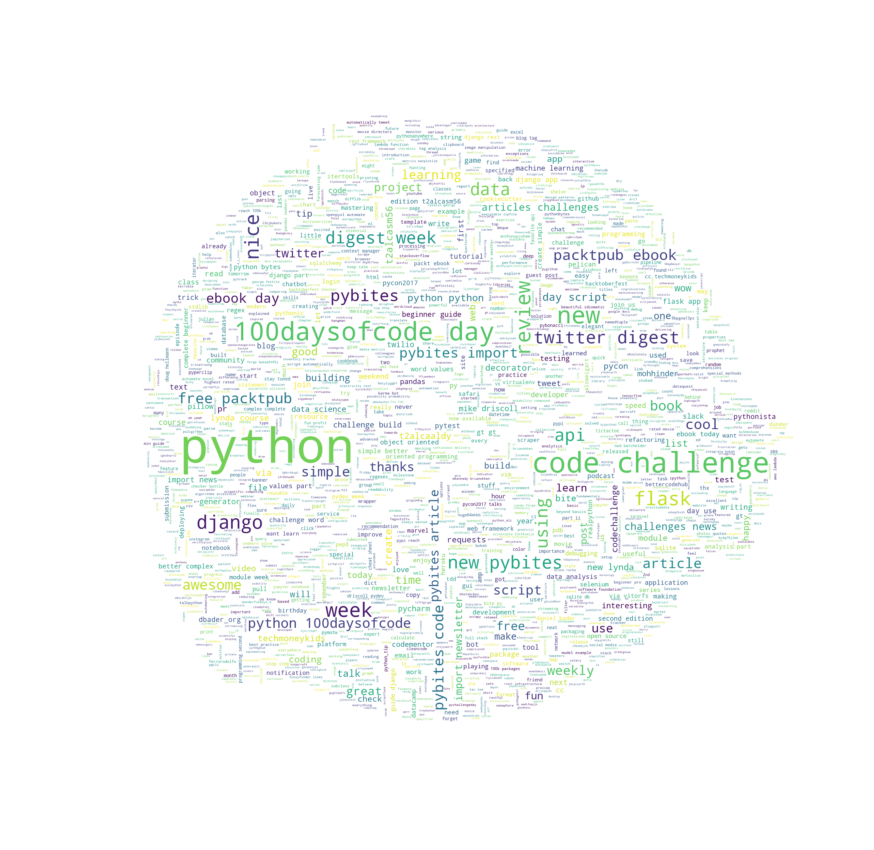

In [21]:
plt.figure(figsize=(15, 15))
plt.imshow(wc, interpolation="bilinear")
plt.margins(x=0, y=0)
plt.axis("off")

### Second and third day - practice, practice, practice:

We covered Twitter data analysis quite extensively on our blog. Below I am listing a combination of tools and challenges you can work on. As they are not small projects I bundled day 2 and 3 to focus on getting one working.

- (__PyBites preferred__)  [How we Automated our 100DaysOfCode Daily Tweet](https://pybit.es/100days-autotweet.html) - seriously: automate this task, it makes your life easier freeing you up to do more coding (it's not only the tweet, Twitter is a distraction everytime you go there ...) - the daily tweet re-enforces commitment to completing the _#100DaysOfCode_! 
    - Related article: [Automate Tweeting: how to build a Twitterbot](https://pybit.es/automate-twitter.html) - nice extension to learn how to POST to the Twitter API

- 3 part code challenge: 
    - [04 - Twitter data analysis Part 1: Getting Data](https://codechalleng.es/challenges/4/)
    - [05 - Twitter data analysis Part 2: Similar Tweeters](https://codechalleng.es/challenges/5/)
    - [07 - Twitter Sentiment Analysis](https://codechalleng.es/challenges/7/) (using a cool module called _TextBlob_)

- You like the testing part? Maybe you can try to mock Twitter API calls, see [Parsing Twitter Geo Data and Mocking API Calls by Example](https://pybit.es/twitter-api-geodata-mocking.html)

- You could also combine this effort with the [Slack API](https://api.slack.com), posting to a channel each time your domain is mentioned, see [here](https://github.com/pybites/100DaysOfCode/blob/master/020/domain_mentions.py) (a tool we still use).

- Or manually draw stats from a downloaded Twitter archive, see [here](https://github.com/pybites/100DaysOfCode/tree/master/086)

- One final option: build a small web app around Twitter data, for example: [Building a Simple Web App With Bottle, SQLAlchemy, and the Twitter API](https://realpython.com/blog/python/building-a-simple-web-app-with-bottle-sqlalchemy-twitter-api/) (here I learned about _Cursor_ as efficient/fast way to retrieve Twitter data). 

- Another Twitter data related project ...

Have fun and remember, keep calm and code in Python!